## Setup

In [ ]:
# tensorflow backend
print('tensorflow backend')
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
print('vae stuff')
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
print('iport scientific py')
import numpy as np
# rdkit stuff
print('rdkit stuff')
from rdkit.Chem import AllChem as Chem
# plotting stuff
print('plotting stuff')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np 

## Load a model

In [ ]:
vae = VAEUtils(directory='models/zinc_properties')

## Decode several attempts

In [53]:
def add_similars(smiles_in, index):
    smiles = mu.canon_smiles(smiles_in)
    X_1 = vae.smiles_to_hot(smiles, canonize_smiles=True)
    Z_1 = vae.encode(X_1)[0]
    noise=4.0
    print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point...'.format(noise))
    df = vae.z_to_smiles( Z_1,decode_attempts=100,noise_norm=noise )
    print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
    Xs = [ vae.smiles_to_hot(mol, canonize_smiles=True) for mol in list(set(df['smiles'])) ]

    mols = [ Chem.MolFromSmiles(smiles) for smiles in list(set(df['smiles'])) ]
    fps = [ Chem.RDKFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    fp_group.extend(list(zip(fpBits, np.full(len(fpBits), index))))
    
    Zs = [ vae.encode(X)[0] for X in Xs ]
    latent_group.extend(list(zip(Zs, np.full(len(Zs), index))))

## Clustering Samples

In [54]:
latent_group = []
fp_group = []
add_similars('N[C@@H](CC1=CNC=N1)C(O)=O', 0)
add_similars('c1ccccc1', 1)
add_similars('NCCC[C@H](N)C(O)=O', 2)
add_similars('N[C@@H](CO)C(O)=O', 3)
add_similars('OC(=O)CCC(O)=O', 4)

Searching molecules randomly sampled from 4.00 std (z-distance) from the point...
Found 9 unique mols, out of 61
Searching molecules randomly sampled from 4.00 std (z-distance) from the point...
Found 16 unique mols, out of 45
Searching molecules randomly sampled from 4.00 std (z-distance) from the point...
Found 12 unique mols, out of 34
Searching molecules randomly sampled from 4.00 std (z-distance) from the point...
Found 6 unique mols, out of 88
Searching molecules randomly sampled from 4.00 std (z-distance) from the point...
Found 32 unique mols, out of 40


In [51]:
mol = Chem.MolFromSmiles('N[C@@H](CC1=CNC=N1)C(O)=O')
fp = Chem.RDKFingerprint(mol) 

## Build DimReduction Model

In [86]:
n_components = 2
model_pca = PCA(n_components=n_components)
model_tsne = TSNE(n_components=n_components)

In [87]:
points_latent_tsne = model_tsne.fit_transform([ points[0] for points in latent_group ])
points_latent_pca = model_pca.fit_transform([ points[0] for points in latent_group ])
points_fp_tsne = model_tsne.fit_transform([ points[0] for points in fp_group ])
points_fp_pca = model_pca.fit_transform([ points[0] for points in fp_group ])

## Visualize the data

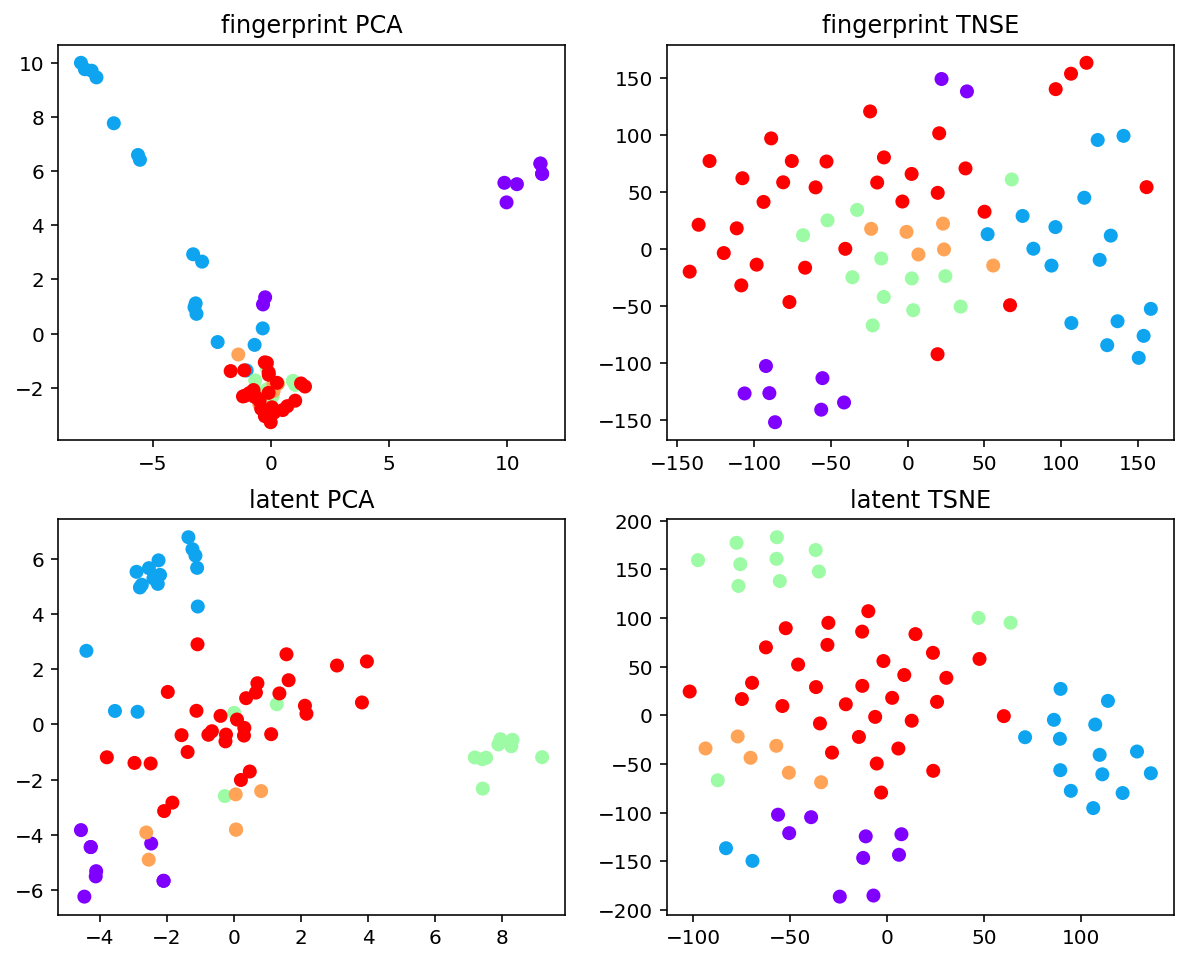

In [91]:
x1 = [ point[0] for point in points_fp_pca ]
y1 = [ point[1] for point in points_fp_pca ]

x2 = [ point[0] for point in points_fp_tsne ]
y2 = [ point[1] for point in points_fp_tsne ]

x3 = [ point[0] for point in points_latent_pca ]
y3 = [ point[1] for point in points_latent_pca ]

x4 = [ point[0] for point in points_latent_tsne ]
y4= [ point[1] for point in points_latent_tsne ]



target = [ item[1] for item in latent_group ]

cmap = plt.cm.get_cmap('rainbow', 10)

plt.subplot(2, 2, 1)
plt.scatter(x1, y1, c=target, cmap=cmap)
plt.title('fingerprint PCA')

plt.subplot(2, 2, 2)
plt.scatter(x2, y2, c=target, cmap=cmap)
plt.title('fingerprint TNSE')

plt.subplot(2, 2, 3) 
plt.scatter(x3, y3, c=target, cmap=cmap)
plt.title('latent PCA')

plt.subplot(2, 2, 4)
plt.scatter(x4, y4, c=target, cmap=cmap)
plt.title('latent TSNE')

plt.rcParams['figure.figsize'] = (10, 8)
plt.show()